In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re 
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
with open('SMSSpamCollection','r') as file:
    text=file.read().lower()

In [24]:
x0=[]
y0=[]
for i in text.split('\n'):
    j=i.split('\t')
    y0.append(j[0])
    x0.append(j[1])

In [25]:
dict1={
    'message':x0,
    'output':y0
}
data=pd.DataFrame(dict1)

In [26]:
le = LabelEncoder()
le.fit(data["output"])
data["output_encoded"] = le.transform(data["output"])

output_classes = le.classes_.tolist()

In [27]:
data['output'].value_counts()

output
ham     4827
spam     747
Name: count, dtype: int64

In [28]:
x_train, x_test = train_test_split(data,test_size=0.25,random_state=10,shuffle=True,stratify=data["output"])
y_train = x_train["output_encoded"].to_numpy()
y_test = x_test["output_encoded"].to_numpy()

In [29]:
ps=PorterStemmer()
#refered online for this..
def pre_pro(some_string):
    
    # To match HTML/XML entities (e.g., &amp;, &lt;, etc.)
    review = re.sub(r"&amp|&lt|&gt|&quot;", "", some_string)

    # Remove URLs
    review = re.sub(r"https?://\S+|www\.\S+", "", review)

    # Keep only alphanumerics, hash tags, whitespace.
    review = re.sub(r"[^a-zA-Z0-9£$€¥₹\s]", " ", review)

    # Remove whitespaces and split into list
    review = " ".join(review.lower().strip().split())

    review = re.findall(r"\b\w+\b", review.lower())
    review=[ps.stem(word) for word in review if word not in stopwords.words('english')]
    review=" ".join(review)
    return review

In [30]:
x_train['message_cleaned']=x_train['message'].apply(pre_pro)
x_test['message_cleaned']=x_test['message'].apply(pre_pro)

In [31]:
x_train['output'].value_counts()

output
ham     3620
spam     560
Name: count, dtype: int64

In [32]:
x_train.head(10)

,message,output,output_encoded,message_cleaned
2219,nice talking to you! please dont forget my pix...,ham,0,nice talk pleas dont forget pix want see
376,can you say what happen,ham,0,say happen
4535,i have no money 4 steve mate! !,ham,0,money 4 steve mate
2374,xmas prize draws! we are trying to contact u. ...,spam,1,xma prize draw tri contact u today draw show 2...
2439,i not busy juz dun wan 2 go so early.. hee..,ham,0,busi juz dun wan 2 go earli hee
4247,well welp is sort of a semiobscure internet thing,ham,0,well welp sort semiobscur internet thing
4683,"haha yeah, 2 oz is kind of a shitload",ham,0,haha yeah 2 oz kind shitload
4040,i cant pick the phone right now. pls send a me...,ham,0,cant pick phone right pl send messag
3612,no. i.ll meet you in the library,ham,0,meet librari
1477,i'm watching lotr w my sis dis aft. so u wan 2...,ham,0,watch lotr w si di aft u wan 2 meet 4 dinner nite


In [33]:
tfv = TfidfVectorizer(
    max_df=0.95,
    min_df=0.01,
    ngram_range=(1, 4),
)
tfv.fit(x_train["message_cleaned"].values)

TfidfVectorizer(max_df=0.95, min_df=0.01, ngram_range=(1, 4))

In [34]:
tokenizer = Tokenizer(num_words=20000)

tokenizer.fit_on_texts(x_train["message_cleaned"])

x_train_tk = tokenizer.texts_to_sequences(x_train["message_cleaned"])
x_train_tk = pad_sequences(x_train_tk)

x_test_tk = tokenizer.texts_to_sequences(x_test["message_cleaned"])
x_test_tk = pad_sequences(x_test_tk, maxlen=x_train_tk.shape[1])

In [35]:
rnn = tf.keras.models.Sequential()

rnn.add(Input(shape=(x_train_tk.shape[1],)))
# Embed Layer
rnn.add(Embedding(len(tokenizer.word_index) + 1, 128))
# LSTMvLayer
rnn.add(LSTM(64))

#Output Layer
rnn.add(Dense(units=2, activation='softmax'))

In [36]:
# Compile the model
rnn.compile(
    optimizer="adam",
    loss="SparseCategoricalCrossentropy",
    metrics=["accuracy"],
)

# Print the model summary
rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 66, 128)        │       796,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 845,826 (3.23 MB)

 Trainable params: 845,826 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stopping = EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [48]:
history = rnn.fit(
    x_train_tk, y_train, epochs=100, batch_size=50,
    validation_split=0.2,
    callbacks=[early_stopping,tensorboard_callback],
)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9833 - val_loss: 0.0651
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 0.9892 - val_loss: 0.0398
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 1.0000 - loss: 3.6969e-04 - val_accuracy: 0.9928 - val_loss: 0.0398
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 - loss: 2.4803e-04 - val_accuracy: 0.9916 - val_loss: 0.0451
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 2.0926e-04 - val_accuracy: 0.9916 - val_loss: 0.0488
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 1.0000 - loss: 1.0343e-04 - val_accuracy: 0.9916 - val_loss: 0.0500
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 1.0000 - loss: 7.5251e-05 - val_accuracy: 0.9916 - val_loss: 0.0515
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 1.0000 - loss: 8.197

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1207
           1       0.98      0.94      0.96       187

    accuracy                           0.99      1394
   macro avg       0.99      0.97      0.98      1394
weighted avg       0.99      0.99      0.99      1394



Text(0.5, 0, 'Predicted values')

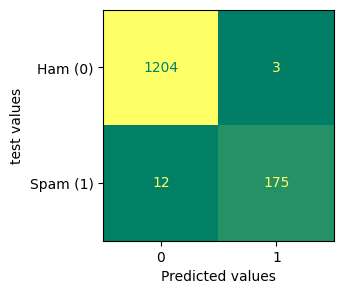

In [49]:
#got code from internet
import matplotlib.pyplot as plt
y_test_pred = np.argmax(rnn.predict(x_test_tk), axis=1)
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[
        f"{label.capitalize().replace('_', ' ')} ({i})"
        for i, label in enumerate(output_classes)
    ],
)
disp.plot(ax=ax, cmap="summer", colorbar=False)
ax.set_xticklabels([i for i, _ in enumerate(output_classes)])
ax.grid(False)
ax.set_ylabel("test values")
ax.set_xlabel("Predicted values")


In [50]:
#plots
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1740), started 0:05:55 ago. (Use '!kill 1740' to kill it.)